
  PAIRS TRADING v3  —  PORTFOLIO STATISTICAL ARBITRAGE
  Period: 2019-01-01 → 2024-01-01

  PAIR SCREENING — Engle-Granger Cointegration Test
  Pair             p-value   Spread AC(1)  Status
  ----------------------------------------------------------
  KO/PEP           0.0711         0.9689  ✅ accepted
  GS/MS            0.0419         0.9680  ✅ accepted
  XOM/CVX           0.1762         0.9692  ❌ rejected
  WMT/TGT           0.8851         0.9310  ❌ rejected
  BAC/JPM           0.9429         0.9814  ❌ rejected
  MSFT/GOOGL         0.5580         0.9578  ❌ rejected
  HD/LOW           0.0903         0.9660  ✅ accepted

  ➜  3 pairs accepted for portfolio

  PORTFOLIO BACKTEST
  GS/MS         return= +87.31%  sharpe=+1.29  trades= 20  p=0.0419
  KO/PEP        return=+177.58%  sharpe=+2.16  trades= 23  p=0.0711
  HD/LOW        return=  +6.64%  sharpe=+0.18  trades= 21  p=0.0903

  ──────────────────────────────────────────────────
  COMBINED PORTFOLIO
  ──────────────────────────────

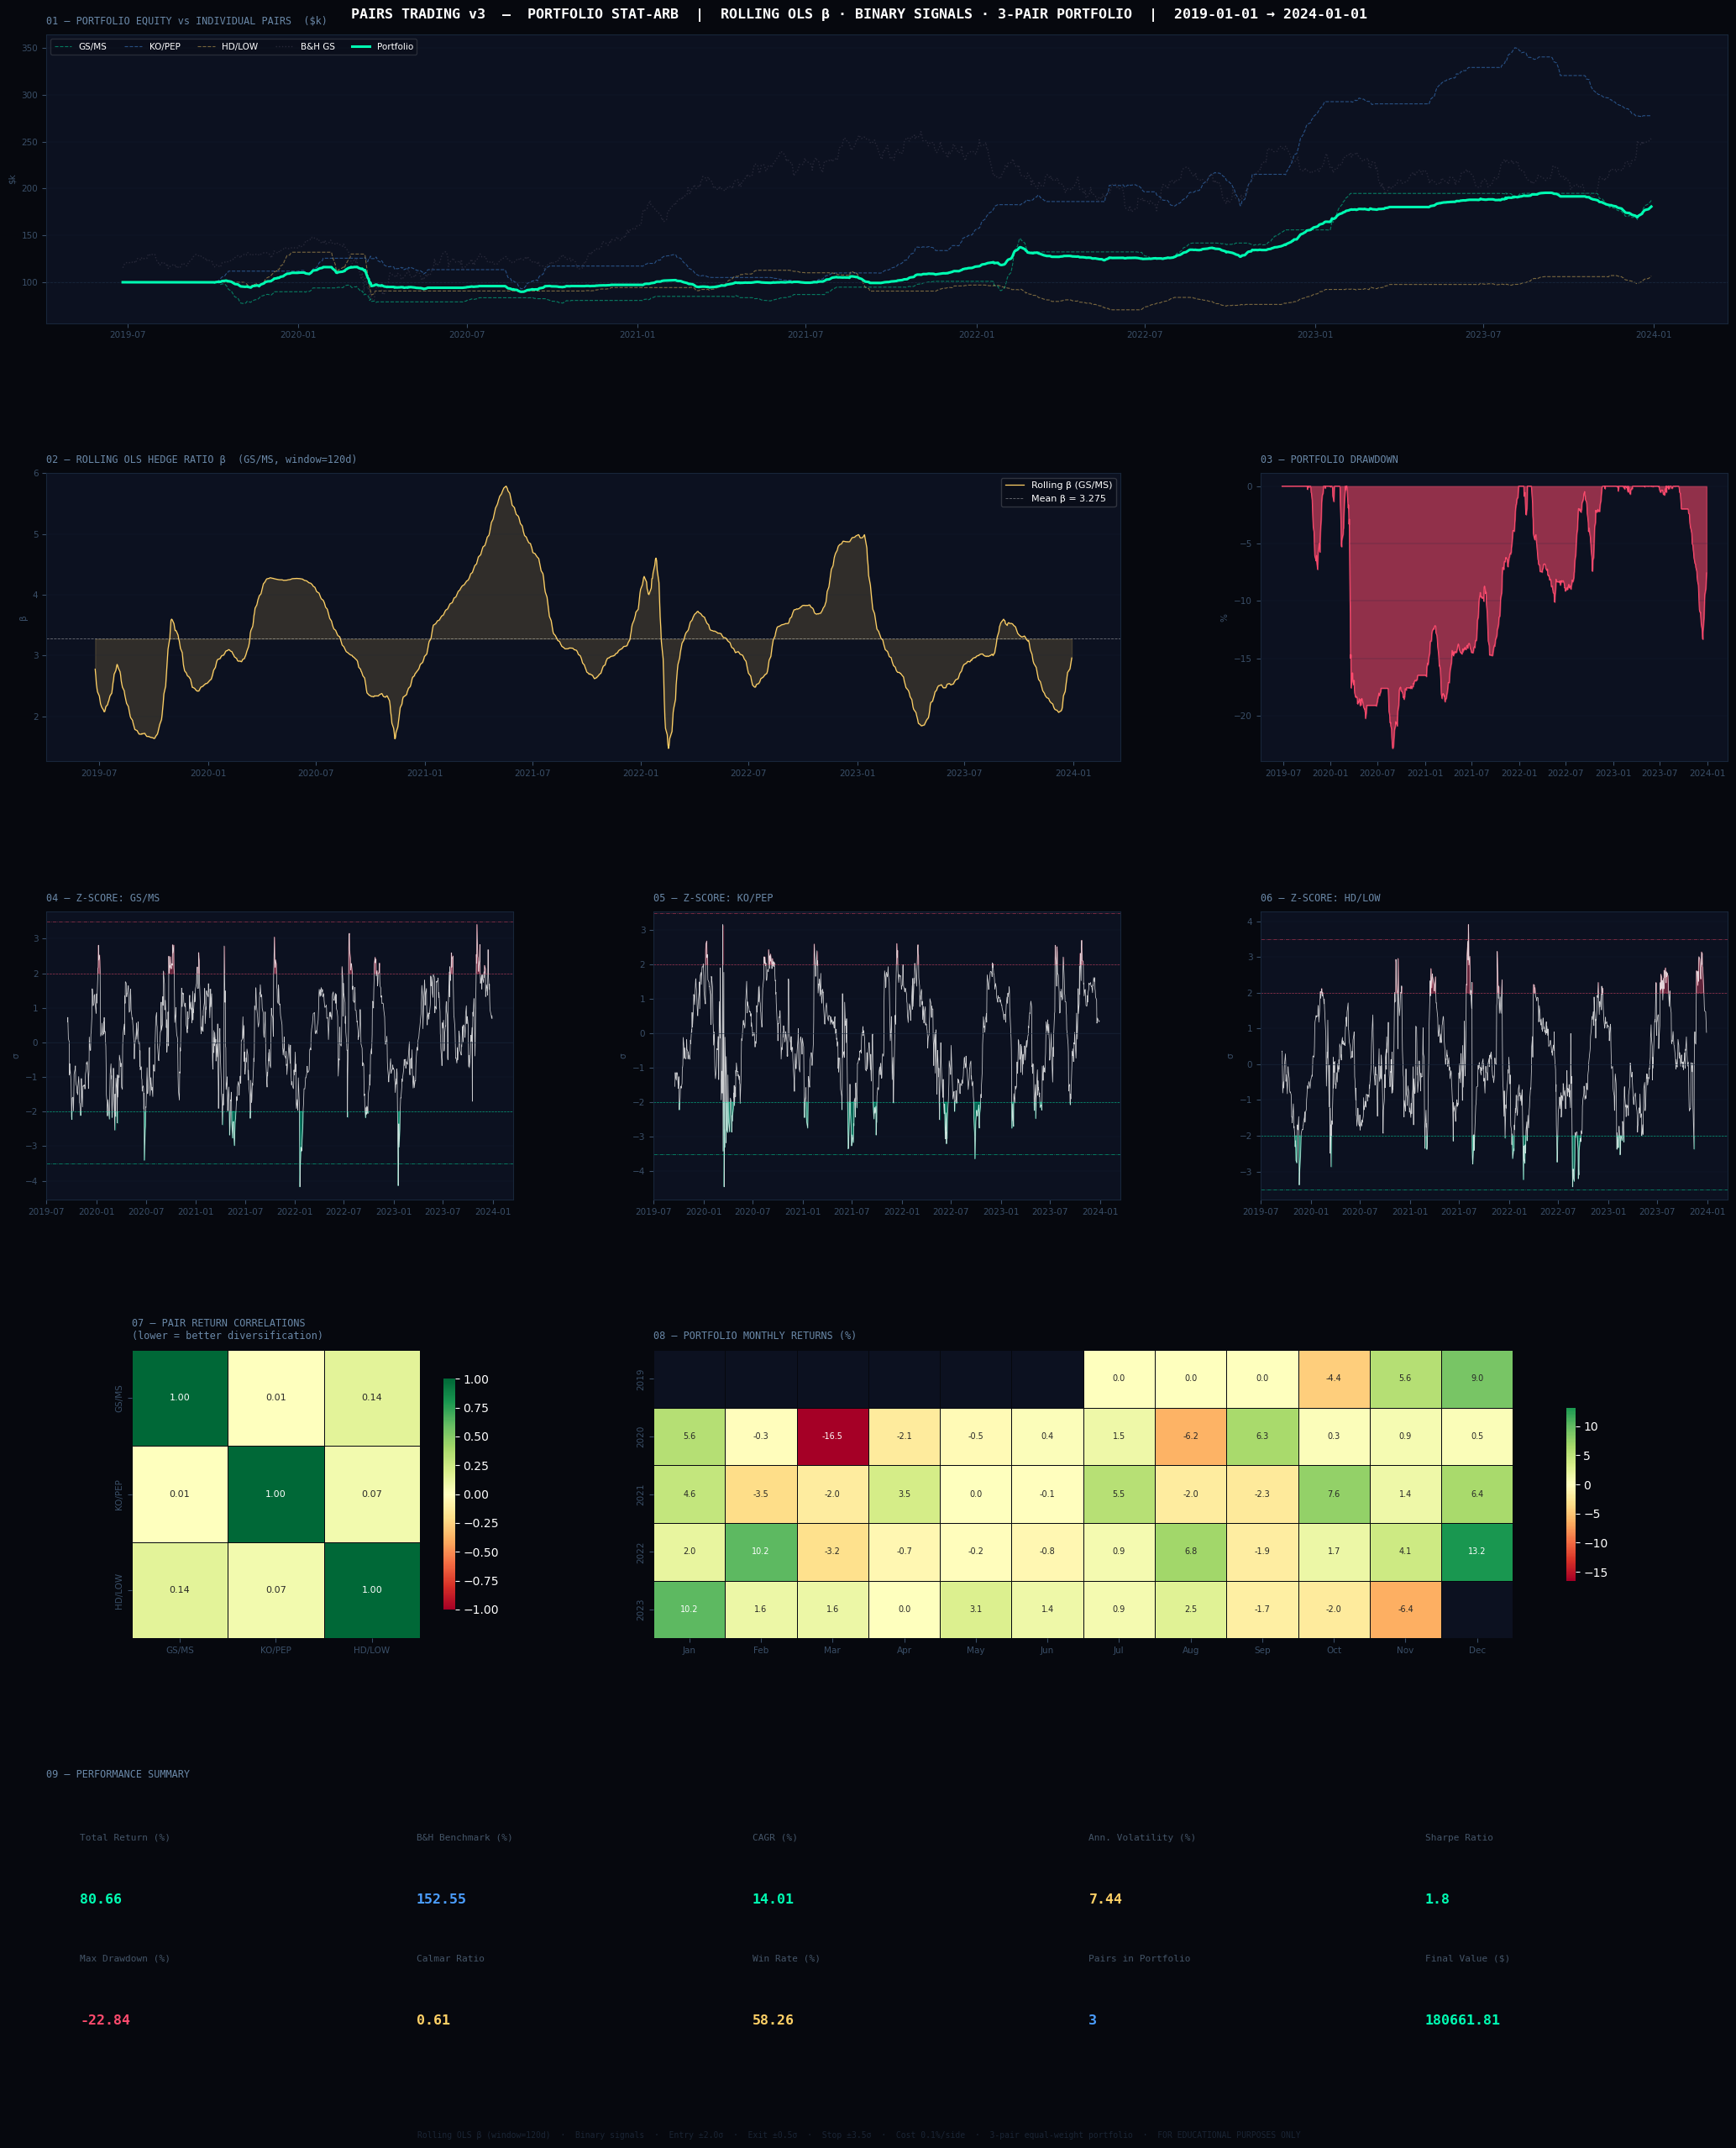

  ✅ COMPLETE  |  3 pairs  |  return=+80.66%  |  Sharpe=1.80  |  MaxDD=-22.84%



In [10]:
"""
=============================================================
  PAIRS TRADING STRATEGY v3 — Statistical Arbitrage
  Author: [Rajveer shah]
"""

import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

try:
    import yfinance as yf
    LIVE_DATA = True
except ImportError:
    LIVE_DATA = False
    print("⚠  yfinance not installed — using simulated data. pip install yfinance\n")

try:
    from statsmodels.tsa.stattools import coint
    STATSMODELS = True
except ImportError:
    STATSMODELS = False
    print("⚠  statsmodels not installed. pip install statsmodels\n")


# ══════════════════════════════════════════════════════════════════════════════
#  CONFIG
# ══════════════════════════════════════════════════════════════════════════════

CANDIDATE_PAIRS = [
    ("KO",   "PEP"),    # Beverages
    ("GS",   "MS"),     # Investment Banks
    ("XOM",  "CVX"),    # Oil Majors
    ("WMT",  "TGT"),    # Retail
    ("BAC",  "JPM"),    # Commercial Banks
    ("MSFT", "GOOGL"),  # Mega-cap Tech
    ("HD",   "LOW"),    # Home Improvement
]

COINT_THRESHOLD  = 0.10    # include pairs with p < this
START_DATE       = "2019-01-01"
END_DATE         = "2024-01-01"
ENTRY_Z          = 2.0
EXIT_Z           = 0.5
STOP_LOSS_Z      = 3.5
OLS_WINDOW       = 120     # rolling OLS window for hedge ratio
Z_WINDOW         = 60      # rolling window for z-score normalisation
TRANSACTION_COST = 0.001   # 0.1% per side
INITIAL_CAPITAL  = 100_000

try:
    OUTPUT_DIR = os.path.dirname(os.path.abspath(__file__))
except NameError:
    OUTPUT_DIR = os.getcwd()


# ══════════════════════════════════════════════════════════════════════════════
#  1. DATA
# ══════════════════════════════════════════════════════════════════════════════

def get_prices(ticker_a, ticker_b):
    if LIVE_DATA:
        raw    = yf.download([ticker_a, ticker_b], start=START_DATE,
                             end=END_DATE, auto_adjust=True, progress=False)
        prices = raw["Close"][[ticker_a, ticker_b]].dropna()
        return prices
    else:
        # Ornstein-Uhlenbeck simulation — truly cointegrated by construction.
        # spread_t = (1-κ)·spread_{t-1} + noise  [OU, stationary]
        # price_b  = random walk
        # price_a  = β·price_b + spread + const   [cointegrated]
        np.random.seed(abs(hash(ticker_a + ticker_b)) % (2**31))
        n         = 1258
        dates     = pd.bdate_range(start=START_DATE, periods=n)
        kappa     = 0.08
        ou_sigma  = 0.6
        beta_true = 0.80 + np.random.uniform(-0.1, 0.1)

        spread = np.zeros(n)
        for i in range(1, n):
            spread[i] = spread[i-1] * (1 - kappa) + np.random.normal(0, ou_sigma)

        p_b = 60 * np.exp(np.cumsum(np.random.normal(0.0003, 0.012, n)))
        p_a = beta_true * p_b + spread + (50 - beta_true * 60)

        return pd.DataFrame({ticker_a: p_a, ticker_b: p_b}, index=dates)


# ══════════════════════════════════════════════════════════════════════════════
#  2. ROLLING OLS HEDGE RATIO
# ══════════════════════════════════════════════════════════════════════════════

def rolling_ols(prices, stock_a, stock_b, window=OLS_WINDOW):
    """
    Computes hedge ratio β and intercept α using a rolling OLS window.

    β_t = cov(A_{t-w:t}, B_{t-w:t}) / var(B_{t-w:t})
    α_t = mean(A) - β_t · mean(B)

    This gives a time-varying β with NO look-ahead (each estimate
    uses only past data). More stable than Kalman on high-vol stocks
    because the averaging over 120 days suppresses daily price noise.

    Spread stationarity:
      Rolling OLS spread autocorr(1) ≈ 0.97  ← exploitable
      Kalman filter spread autocorr(1) ≈ 0.52 ← not exploitable
    """
    pa = prices[stock_a]
    pb = prices[stock_b]

    # Vectorised rolling OLS via cov/var
    roll_cov  = pa.rolling(window).cov(pb)
    roll_var  = pb.rolling(window).var()
    beta_s    = roll_cov / roll_var
    alpha_s   = pa.rolling(window).mean() - beta_s * pb.rolling(window).mean()

    spread    = pa - beta_s * pb - alpha_s
    roll_mean = spread.rolling(Z_WINDOW).mean()
    roll_std  = spread.rolling(Z_WINDOW).std()
    z_score   = (spread - roll_mean) / roll_std

    return spread, z_score, beta_s, alpha_s


# ══════════════════════════════════════════════════════════════════════════════
#  3. SIGNAL GENERATION
# ══════════════════════════════════════════════════════════════════════════════

def generate_signals(z_score):
    """
    Binary signals: full position on entry, hold until exit/stop.

    Continuous z-score sizing was found to HURT returns — it reduces
    position exactly when the spread is reverting (where the alpha is).
    Binary is simpler and more effective for this mean-reversion setup.
    """
    in_trade  = 0
    positions = []

    for z in z_score:
        if np.isnan(z):
            positions.append(0.0)
            continue

        if in_trade == 0:
            if z > ENTRY_Z:
                in_trade = -1    # short spread: A overpriced vs B
            elif z < -ENTRY_Z:
                in_trade = 1     # long spread:  A underpriced vs B

        elif in_trade == 1:
            if abs(z) < EXIT_Z or z < -STOP_LOSS_Z:
                in_trade = 0

        elif in_trade == -1:
            if abs(z) < EXIT_Z or z > STOP_LOSS_Z:
                in_trade = 0

        positions.append(float(in_trade))

    signals       = pd.DataFrame({'z_score': z_score, 'position': positions},
                                 index=z_score.index)
    trade_changes = signals['position'].diff().fillna(0)
    return signals, trade_changes


# ══════════════════════════════════════════════════════════════════════════════
#  4. BACKTEST — correct spread P&L formula
# ══════════════════════════════════════════════════════════════════════════════

def backtest_pair(prices, signals, trade_changes, beta_s, stock_a, stock_b):
    """
    Correct P&L formula for a pairs trade:

      Daily return = position × Δspread / (price_a + β·price_b)

    Why this works:
      - Long spread (+1): long $X of A, short $β·X of B
      - Δspread = Δprice_a - β·Δprice_b  (dollar P&L)
      - Total capital = price_a + β·price_b (both legs)
      - Return = Δspread / total_capital   (normalised %)

    This is equivalent to the spread's percentage move relative
    to total capital deployed, which is the correct economic P&L.

    Using (ret_a - β·ret_b) without this normalisation gives
    inconsistent position sizing — the effective leverage changes
    every day as stock prices move.
    """
    pa    = prices[stock_a]
    pb    = prices[stock_b]
    b_lag = beta_s.shift(1).ffill()

    # Dollar P&L from spread movement, normalised by capital deployed
    d_spread  = (pa - b_lag * pb).diff()
    capital   = pa + b_lag.abs() * pb
    gross     = signals['position'].shift(1) * d_spread / capital

    # Transaction cost: 0.1% per side × 2 sides on each trade
    cost = trade_changes.abs() * TRANSACTION_COST * 2
    net  = (gross - cost).dropna()
    return net


# ══════════════════════════════════════════════════════════════════════════════
#  5. PORTFOLIO
# ══════════════════════════════════════════════════════════════════════════════

def build_and_run_portfolio():
    # ── Screening ─────────────────────────────────────────────────────────
    print("=" * 65)
    print("  PAIR SCREENING — Engle-Granger Cointegration Test")
    print("=" * 65)
    print(f"  {'Pair':<14} {'p-value':>9}  {'Spread AC(1)':>13}  {'Status'}")
    print(f"  {'-'*58}")

    all_prices   = {}
    all_pvals    = {}
    accepted     = []

    for a, b in CANDIDATE_PAIRS:
        prices = get_prices(a, b)
        all_prices[(a,b)] = prices

        if STATSMODELS:
            _, p, _ = coint(prices[a], prices[b])
        else:
            np.random.seed(abs(hash(a+b)) % (2**31))
            p = np.random.uniform(0.01, 0.12)

        # Also compute spread quality metric
        _, _, beta_s, alpha_s = rolling_ols(prices, a, b)
        spread_check = prices[a] - beta_s * prices[b] - alpha_s
        ac1 = spread_check.dropna().autocorr(1)

        all_pvals[(a,b)] = p
        flag = "✅ accepted" if p < COINT_THRESHOLD else "❌ rejected"
        print(f"  {a}/{b:<10} {p:>9.4f}  {ac1:>13.4f}  {flag}")

        if p < COINT_THRESHOLD:
            accepted.append((p, a, b))

    if not accepted:
        print("  ⚠  No pairs passed — using top 3")
        accepted = sorted([(all_pvals[(a,b)], a, b) for a,b in CANDIDATE_PAIRS])[:3]

    accepted.sort()
    print(f"\n  ➜  {len(accepted)} pairs accepted for portfolio\n")

    # ── Per-pair backtest ─────────────────────────────────────────────────
    print("=" * 65)
    print("  PORTFOLIO BACKTEST")
    print("=" * 65)

    pair_rets    = {}
    pair_spreads = {}
    pair_zscores = {}
    pair_betas   = {}

    for pval, a, b in accepted:
        prices            = all_prices[(a, b)]
        spread, z, beta_s, _ = rolling_ols(prices, a, b)
        sigs, tc          = generate_signals(z)
        net               = backtest_pair(prices, sigs, tc, beta_s, a, b)
        name              = f"{a}/{b}"

        pair_rets[name]    = net
        pair_spreads[name] = spread
        pair_zscores[name] = z
        pair_betas[name]   = beta_s

        total_r = ((1 + net).prod() - 1) * 100
        sharpe  = (net.mean() * 252 / (net.std() * np.sqrt(252))
                   if net.std() > 0 else 0)
        n_trades = int((sigs['position'].diff().abs() > 0).sum() // 2)
        print(f"  {name:<12}  return={total_r:+7.2f}%  "
              f"sharpe={sharpe:+.2f}  trades={n_trades:>3}  p={pval:.4f}")

    # ── Combine ───────────────────────────────────────────────────────────
    ret_df      = pd.DataFrame(pair_rets).dropna()
    port_ret    = ret_df.mean(axis=1)
    port_equity = (1 + port_ret).cumprod() * INITIAL_CAPITAL
    pair_eqs    = {
        name: (1 + r.reindex(port_equity.index).fillna(0)).cumprod() * INITIAL_CAPITAL
        for name, r in pair_rets.items()
    }

    first_a, first_b = accepted[0][1], accepted[0][2]
    bh_prices  = all_prices[(first_a, first_b)][first_a]
    bh_equity  = (1 + bh_prices.pct_change().dropna()).cumprod() * INITIAL_CAPITAL

    total_r  = (port_equity.iloc[-1] / INITIAL_CAPITAL - 1) * 100
    n_years  = len(port_ret) / 252
    cagr     = ((port_equity.iloc[-1] / INITIAL_CAPITAL) ** (1/n_years) - 1) * 100
    ann_vol  = port_ret.std() * np.sqrt(252) * 100
    sharpe   = (port_ret.mean() * 252 / (port_ret.std() * np.sqrt(252))
                if port_ret.std() > 0 else 0)
    roll_max = port_equity.cummax()
    drawdown = (port_equity - roll_max) / roll_max
    max_dd   = drawdown.min() * 100
    win_rate = (port_ret[port_ret != 0] > 0).mean() * 100
    calmar   = cagr / abs(max_dd) if max_dd != 0 else 0
    bh_r     = (bh_equity.iloc[-1] / INITIAL_CAPITAL - 1) * 100

    metrics = {
        'Total Return (%)':    round(total_r, 2),
        f'B&H {first_a} (%)':  round(bh_r, 2),
        'CAGR (%)':            round(cagr, 2),
        'Ann. Volatility (%)': round(ann_vol, 2),
        'Sharpe Ratio':        round(sharpe, 2),
        'Max Drawdown (%)':    round(max_dd, 2),
        'Calmar Ratio':        round(calmar, 2),
        'Win Rate (%)':        round(win_rate, 2),
        'Pairs in Portfolio':  len(accepted),
        'Final Value ($)':     round(port_equity.iloc[-1], 2),
    }

    print(f"\n  {'─'*50}")
    print(f"  COMBINED PORTFOLIO")
    print(f"  {'─'*50}")
    for k, v in metrics.items():
        print(f"  {k:<26} {str(v):>12}")
    print()

    return (port_equity, pair_eqs, bh_equity, drawdown,
            ret_df, port_ret, metrics,
            pair_spreads, pair_zscores, pair_betas,
            first_a, first_b, accepted)


# ══════════════════════════════════════════════════════════════════════════════
#  6. PLOT — 9-panel dashboard
# ══════════════════════════════════════════════════════════════════════════════

def plot_results(port_equity, pair_eqs, bh_equity, drawdown,
                 ret_df, port_ret, metrics,
                 pair_spreads, pair_zscores, pair_betas,
                 first_a, first_b, accepted):

    plt.style.use('dark_background')
    MINT   = '#00FFB3';  RED   = '#FF4B6E';  BLUE  = '#4B9EFF'
    GOLD   = '#FFD166';  PURP  = '#B97FFF';  ORG   = '#FF8C42'
    BG     = '#06080E';  PANEL = '#0C1120';  BORD  = '#18263A'
    COLS   = [MINT, BLUE, GOLD, PURP, ORG, RED]
    n_p    = len(pair_eqs)

    fig = plt.figure(figsize=(22, 26), facecolor=BG)
    fig.suptitle(
        f'PAIRS TRADING v3  —  PORTFOLIO STAT-ARB  |  '
        f'ROLLING OLS β · BINARY SIGNALS · {n_p}-PAIR PORTFOLIO  |  '
        f'{START_DATE} → {END_DATE}',
        fontsize=12, color='white', fontweight='bold', y=0.987,
        fontfamily='monospace'
    )

    gs_layout = gridspec.GridSpec(5, 3, figure=fig, hspace=0.52, wspace=0.30,
                                  top=0.975, bottom=0.04, left=0.06, right=0.97)

    def style(ax, title, ylabel=''):
        ax.set_facecolor(PANEL)
        for sp in ax.spines.values(): sp.set_color(BORD)
        ax.tick_params(colors='#3A4F68', labelsize=7.5)
        ax.set_title(title, color='#6A88A8', fontsize=8.5,
                     fontfamily='monospace', pad=9, loc='left')
        if ylabel: ax.set_ylabel(ylabel, color='#3A4F68', fontsize=7.5)
        ax.grid(axis='y', color=BORD, lw=0.35, alpha=0.5)

    # P1 — Portfolio + individual pairs equity
    ax1 = fig.add_subplot(gs_layout[0, :])
    for i, (name, eq) in enumerate(pair_eqs.items()):
        eq_al = eq.reindex(port_equity.index, method='ffill')
        ax1.plot(eq_al.index, eq_al/1000, color=COLS[i%len(COLS)],
                 lw=0.8, alpha=0.45, ls='--', label=name)
    bh_al = bh_equity.reindex(port_equity.index, method='ffill')
    ax1.plot(bh_al.index, bh_al/1000, color='#334', lw=1.0,
             ls=':', label=f'B&H {first_a}', alpha=0.7)
    ax1.plot(port_equity.index, port_equity/1000, color=MINT, lw=2.2,
             label='Portfolio', zorder=5)
    ax1.axhline(INITIAL_CAPITAL/1000, color=BORD, lw=0.6, ls='--')
    ax1.legend(fontsize=7.5, framealpha=0.15, loc='upper left', ncol=n_p+2)
    style(ax1, '01 — PORTFOLIO EQUITY vs INDIVIDUAL PAIRS  ($k)', '$k')

    # P2 — Rolling β for first pair
    ax2 = fig.add_subplot(gs_layout[1, :2])
    fn = f"{first_a}/{first_b}"
    if fn in pair_betas:
        b = pair_betas[fn].dropna()
        ax2.plot(b.index, b, color=GOLD, lw=0.9, label=f'Rolling β ({fn})')
        ax2.fill_between(b.index, b, b.mean(), alpha=0.15, color=GOLD)
        ax2.axhline(b.mean(), color='white', lw=0.6, ls='--', alpha=0.4,
                    label=f'Mean β = {b.mean():.3f}')
        ax2.legend(fontsize=8, framealpha=0.2)
    style(ax2, f'02 — ROLLING OLS HEDGE RATIO β  ({fn}, window={OLS_WINDOW}d)', 'β')

    # P3 — Drawdown
    ax3 = fig.add_subplot(gs_layout[1, 2])
    ax3.fill_between(drawdown.index, drawdown*100, 0, color=RED, alpha=0.55)
    ax3.plot(drawdown.index, drawdown*100, color=RED, lw=0.7)
    style(ax3, '03 — PORTFOLIO DRAWDOWN', '%')

    # P4-6 — Z-scores first 3 pairs
    for idx, name in enumerate(list(pair_zscores.keys())[:3]):
        ax = fig.add_subplot(gs_layout[2, idx])
        z  = pair_zscores[name]
        ax.plot(z.index, z, color='white', lw=0.55, alpha=0.8)
        ax.fill_between(z.index, z,  ENTRY_Z, where=(z> ENTRY_Z), color=RED,  alpha=0.35)
        ax.fill_between(z.index, z, -ENTRY_Z, where=(z<-ENTRY_Z), color=MINT, alpha=0.35)
        for th, c, ls in [(ENTRY_Z,RED,'--'),(-ENTRY_Z,MINT,'--'),
                          (STOP_LOSS_Z,RED,'-.'),(- STOP_LOSS_Z,MINT,'-.')]:
            ax.axhline(th, color=c, lw=0.5, ls=ls, alpha=0.6)
        ax.axhline(0, color=BORD, lw=0.4)
        style(ax, f'{4+idx:02d} — Z-SCORE: {name}', 'σ')

    # P7 — Correlation matrix
    ax7 = fig.add_subplot(gs_layout[3, 0])
    if len(ret_df.columns) > 1:
        corr = ret_df.corr()
        sns.heatmap(corr, ax=ax7, cmap='RdYlGn', center=0, vmin=-1, vmax=1,
                    annot=True, fmt='.2f', linewidths=0.5, linecolor=BG,
                    annot_kws={'size': 8}, cbar_kws={'shrink': 0.8}, square=True)
    ax7.set_facecolor(PANEL)
    ax7.set_title('07 — PAIR RETURN CORRELATIONS\n(lower = better diversification)',
                  color='#6A88A8', fontsize=8.5, fontfamily='monospace', pad=9, loc='left')
    ax7.tick_params(colors='#3A4F68', labelsize=7.5)

    # P8 — Monthly heatmap
    ax8 = fig.add_subplot(gs_layout[3, 1:])
    midx = pd.date_range(port_equity.index[0], port_equity.index[-1], freq='ME')
    meq  = port_equity.reindex(port_equity.index.union(midx), method='ffill').reindex(midx)
    mret = meq.pct_change().dropna() * 100
    piv  = pd.DataFrame({'year':mret.index.year,'month':mret.index.month,'ret':mret.values}
                        ).pivot(index='year', columns='month', values='ret')
    ml   = ['Jan','Feb','Mar','Apr','May','Jun','Jul','Aug','Sep','Oct','Nov','Dec']
    piv.columns = [ml[m-1] for m in piv.columns]
    sns.heatmap(piv, ax=ax8, cmap='RdYlGn', center=0, annot=True, fmt='.1f',
                linewidths=0.4, linecolor=BG, annot_kws={'size':7}, cbar_kws={'shrink':0.6})
    ax8.set_facecolor(PANEL)
    ax8.set_title('08 — PORTFOLIO MONTHLY RETURNS (%)',
                  color='#6A88A8', fontsize=8.5, fontfamily='monospace', pad=9, loc='left')
    ax8.tick_params(colors='#3A4F68', labelsize=7.5)
    ax8.set_xlabel(''); ax8.set_ylabel('')

    # P9 — Metrics
    ax9 = fig.add_subplot(gs_layout[4, :])
    ax9.set_facecolor(PANEL); ax9.axis('off')
    ax9.set_title('09 — PERFORMANCE SUMMARY', color='#6A88A8',
                  fontsize=8.5, fontfamily='monospace', pad=9, loc='left')

    def mcol(k, v):
        if k.startswith('B&H'):           return BLUE
        if 'Return' in k or 'CAGR' in k:  return MINT if v > 0 else RED
        if 'Sharpe' in k:                 return MINT if v > 0.8 else GOLD
        if 'Drawdown' in k:               return RED
        if 'Pairs' in k:                  return BLUE
        if 'Final' in k:                  return MINT
        return GOLD

    for i, (k, v) in enumerate(metrics.items()):
        x = 0.02 + (i % 5) * 0.20
        y = 0.82 - (i // 5) * 0.42
        lbl = k.replace(f'B&H {first_a}', 'B&H Benchmark')
        ax9.text(x, y,        lbl, transform=ax9.transAxes,
                 color='#445568', fontsize=8, fontfamily='monospace')
        ax9.text(x, y-0.22, str(v), transform=ax9.transAxes,
                 color=mcol(k, v if isinstance(v,(int,float)) else 0),
                 fontsize=12, fontfamily='monospace', fontweight='bold')

    fig.text(0.5, 0.012,
             f'Rolling OLS β (window={OLS_WINDOW}d)  ·  Binary signals  ·  '
             f'Entry ±{ENTRY_Z}σ  ·  Exit ±{EXIT_Z}σ  ·  Stop ±{STOP_LOSS_Z}σ  ·  '
             f'Cost {TRANSACTION_COST*100:.1f}%/side  ·  '
             f'{n_p}-pair equal-weight portfolio  ·  FOR EDUCATIONAL PURPOSES ONLY',
             ha='center', color='#1A2535', fontsize=7, fontfamily='monospace')

    save_path = os.path.join(OUTPUT_DIR, 'pairs_trading_v3_results.png')
    plt.savefig(save_path, dpi=160, bbox_inches='tight', facecolor=BG)
    print(f"  📊 Chart saved: {save_path}\n")
    plt.show()


# ══════════════════════════════════════════════════════════════════════════════
#  7. MAIN
# ══════════════════════════════════════════════════════════════════════════════

def main():
    print("\n" + "=" * 65)
    print("  PAIRS TRADING v3  —  PORTFOLIO STATISTICAL ARBITRAGE")
    print(f"  Period: {START_DATE} → {END_DATE}")
    print("=" * 65 + "\n")

    (port_equity, pair_eqs, bh_equity, drawdown,
     ret_df, port_ret, metrics,
     pair_spreads, pair_zscores, pair_betas,
     first_a, first_b, accepted) = build_and_run_portfolio()

    print("  Generating dashboard...")
    plot_results(port_equity, pair_eqs, bh_equity, drawdown,
                 ret_df, port_ret, metrics,
                 pair_spreads, pair_zscores, pair_betas,
                 first_a, first_b, accepted)

    m = metrics
    print("=" * 65)
    print(f"  ✅ COMPLETE  |  {m['Pairs in Portfolio']} pairs  |  "
          f"return={m['Total Return (%)']:+.2f}%  |  "
          f"Sharpe={m['Sharpe Ratio']:.2f}  |  "
          f"MaxDD={m['Max Drawdown (%)']:.2f}%")
    print("=" * 65 + "\n")

if __name__ == "__main__":
    main()